# Task 1

#### The Number Of Configurations
Let us start with counting the number of configurations for 9 cards. There are $9!$ permutations of 9 cards, and for each permutation we have $4^9$ different configurations (each card can take 4 turns). That is why the total number of game configurations is $9! \cdot 4^9 = 95 126 814 720$, which is **more than 95 billions card layouts**. If we exclude symmetries, since the game layout can be rotated without consequences, we can reduce the number of configurations by 4, which is about 23 billions configurations in total. Moreover, getting rid of the symmetries, we reach only one possible solution to the puzzle, its rotations get eliminated. The appropriate algorithm was devised. The crucial part of it is choosing the central card first, regardless of its rotation (the same would not work with other cards since their rotation matters). Then, we choose the immediate neighbours of the picked central card, and finally, we choose corners. If the algorithm fails to find a solution on some step, we try out a different card combination.  
  
#### Algorithm  
In a very simplified manner, the algorithm can be represented with the pseudocode:
<img src="pseudocode.png"></img>  
  
The card field is partitioned like this:
<img src="structure.png"></img>  
  
#### The Upper Bound
The code below utilizes the observation that no card has two identical houses on its sides. Thus, if one card is fixed and the other one should be rotated so that it matches the given side, then there is only one such rotation. Therefore, if there is a list of four cards, each of which should be matched to the central card from its respective side (top, right, bottom or left), then there is at most one such matching. This fact reduces the theoretical upper bound of operations needed.  
  
Let us calculate the upper bound: $9 \cdot P^{8}_4 \cdot (4 \cdot 4 + 4! \cdot (4 \cdot 4 + 4)) = 9 \cdot 1680 \cdot 496 = 7 499 520$ - i.e., **less than 7.5 millions operations**. $9$ comes from 9 ways to choose the central card, $P^{8}_4$ is the number of different permutations of 4 cards out of 8 unused cards, $4 \cdot 4$ is the maximum number of card comparisons to check if there is a matching between the central card and current neighbours (4 cards and 4 rotations for each); as soon as the matching is found, we choose some permutation of 4 residual cards (there are $4!$ permutations) and for each such permutation we try to fit the cards into corners (4 rotations for each, at most $16 + 4$ comparison operations, 4 operations are extra-comparisons with the second neighbouring card in a corner). 

In [11]:
from copy import copy, deepcopy
from enum import Enum
from itertools import permutations
from time import perf_counter as timer

In [12]:
operations_counter = 0

In [13]:
class Color(Enum):
    RED = 0
    GREEN = 1
    BLUE = 2
    YELLOW = 3
    

class Side(Enum):
    DOORSIDE = 0
    WINDOWSIDE = 1
    

class House:
    def __init__(self, side, color):
        self.side = side
        self.color = color
    
    def __eq__(self, other):
        if isinstance(other, House):
            global operations_counter
            operations_counter += 1
            return self.side != other.side and self.color == other.color
        return False

In [14]:
class Card:
    # houses are described from the top side clockwise
    def __init__(self, id, houses):
        self.id = id
        self.rotation = 0
        self.top = houses[0]
        self.right = houses[1]
        self.bottom = houses[2]
        self.left = houses[3]
        
    def rotate_cw(self):
        top, right, bottom, left = self.top, self.right, self.bottom, self.left
        
        self.top = left
        self.right = top
        self.bottom = right
        self.left = bottom
        
        self.rotation = (self.rotation + 1) % 4
    
    def do_match(self, other, side):
        if side == 'top':
            if self.top == other.bottom:
                return True
        elif side == 'right':
            if self.right == other.left:
                return True
        elif side == 'bottom':
            if self.bottom == other.top:
                return True
        elif side == 'left':
            if self.left == other.right:
                return True
        
        return False

In [15]:
class Game:
    def __init__(self, cards):
        self.cards = deepcopy(cards)
        
    # tries to match a movable card to some side of a fixed card; 
    # if there isn't such a match, False is returned
    def __match(self, fixed, movable, side):
        for i in range(4):
            if fixed.do_match(movable, side):
                return True
            movable.rotate_cw()
        
        return False

    def __build_solution(self, center, neighbours, corners):
        solution = copy(self.cards)
        
        solution[0][0] = corners[0]
        solution[0][2] = corners[1]
        solution[2][2] = corners[2]
        solution[2][0] = corners[3]
        
        solution[0][1] = neighbours[0]
        solution[1][2] = neighbours[1]
        solution[2][1] = neighbours[2]
        solution[1][0] = neighbours[3]
        
        solution[1][1] = center
        
        return solution

    def solve(self):
        cards_copy = deepcopy(cards)
        cards_list = [card for sublist in cards_copy for card in sublist]
        
        for i, center in enumerate(cards_list):
            cards_around = copy(cards_list)
            cards_around.pop(i)
            
            for neighbours in permutations(cards_around, 4):
                if self.__match(center, neighbours[0], 'top') and \
                self.__match(center, neighbours[1], 'right') and \
                self.__match(center, neighbours[2], 'bottom') and \
                self.__match(center, neighbours[3], 'left'):
                    
                    cards_left = [card for card in cards_around if card not in neighbours]
                    for corners in permutations(cards_left):
                        if self.__match(neighbours[0], corners[0], 'left') and neighbours[3].do_match(corners[0], 'top') and \
                        self.__match(neighbours[0], corners[1], 'right') and neighbours[1].do_match(corners[1], 'top') and \
                        self.__match(neighbours[2], corners[2], 'right') and neighbours[1].do_match(corners[2], 'bottom') and \
                        self.__match(neighbours[2], corners[3], 'left') and neighbours[3].do_match(corners[3], 'bottom'):      
                            return self.__build_solution(center, neighbours, corners)
        
        return None

#### Solving The Given Puzzle

In [16]:
cards = [[Card(0, [House(Side.DOORSIDE, Color.GREEN), 
                   House(Side.WINDOWSIDE, Color.YELLOW), 
                   House(Side.WINDOWSIDE, Color.RED), 
                   House(Side.DOORSIDE, Color.BLUE)]), 
          
          Card(1, [House(Side.WINDOWSIDE, Color.GREEN), 
                   House(Side.WINDOWSIDE, Color.BLUE), 
                   House(Side.WINDOWSIDE, Color.YELLOW), 
                   House(Side.DOORSIDE, Color.RED)]), 
          
          Card(2, [House(Side.DOORSIDE, Color.BLUE), 
                   House(Side.WINDOWSIDE, Color.GREEN), 
                   House(Side.WINDOWSIDE, Color.BLUE), 
                   House(Side.DOORSIDE, Color.RED)])],
        
         
        [Card(3, [House(Side.DOORSIDE, Color.GREEN), 
                   House(Side.DOORSIDE, Color.BLUE), 
                   House(Side.WINDOWSIDE, Color.YELLOW), 
                   House(Side.DOORSIDE, Color.RED)]), 
          
          Card(4, [House(Side.WINDOWSIDE, Color.RED), 
                   House(Side.DOORSIDE, Color.YELLOW), 
                   House(Side.WINDOWSIDE, Color.YELLOW), 
                   House(Side.WINDOWSIDE, Color.BLUE)]), 
          
          Card(5, [House(Side.WINDOWSIDE, Color.GREEN), 
                   House(Side.DOORSIDE, Color.RED), 
                   House(Side.DOORSIDE, Color.YELLOW), 
                   House(Side.WINDOWSIDE, Color.BLUE)])],
        
         
        [Card(6, [House(Side.DOORSIDE, Color.YELLOW), 
                   House(Side.WINDOWSIDE, Color.BLUE), 
                   House(Side.DOORSIDE, Color.GREEN), 
                   House(Side.WINDOWSIDE, Color.RED)]), 
          
          Card(7, [House(Side.WINDOWSIDE, Color.GREEN), 
                   House(Side.DOORSIDE, Color.RED), 
                   House(Side.DOORSIDE, Color.GREEN), 
                   House(Side.DOORSIDE, Color.YELLOW)]), 
          
          Card(8, [House(Side.WINDOWSIDE, Color.GREEN), 
                   House(Side.WINDOWSIDE, Color.YELLOW), 
                   House(Side.DOORSIDE, Color.BLUE), 
                   House(Side.DOORSIDE, Color.RED)])]]

In [19]:
game = Game(cards)
operations_counter = 0

start = timer()
solution = game.solve()
end = timer()

print(f"Operations needed: {operations_counter} \nElapsed time: {end - start} s")

Operations needed: 105261 
Elapsed time: 0.09933279999950173 s


In [64]:
for row in solution:
    for card in row:
        print(f"id: {card.id}; rotations (90* clockwise): {card.rotation}")

id: 7; rotations (90* clockwise): 2
id: 3; rotations (90* clockwise): 1
id: 1; rotations (90* clockwise): 3
id: 0; rotations (90* clockwise): 0
id: 5; rotations (90* clockwise): 1
id: 6; rotations (90* clockwise): 1
id: 2; rotations (90* clockwise): 1
id: 4; rotations (90* clockwise): 0
id: 8; rotations (90* clockwise): 2


<img src='solved.png'></img>

# Task 2

#### Basic Algorithm
The algorithm for differential evolution was taken from here https://en.wikipedia.org/wiki/Differential_evolution. The parameters include population size $\mathrm{NP} \geq 4$, crossover probability $\mathrm{CR} \in [0, 1]$ and differential weight $\mathrm{F} \in [0, 2]$. Typical settings are $\mathrm{F} = 0.8$ and $\mathrm{CR} = 0.9$.  
  
The proposed algorithm:
1. Initialize all agents $\mathbf{x}$  with random positions in the search-space.
2. Until a termination criterion is met, repeat the following: 
* For each agent $\mathbf{x}$  in the population do:
    * Pick three agents $\mathbf{a}$, $\mathbf{b}$ and $\mathbf{c}$ from the population at random, they must be distinct from each other as well as from agent $\mathbf{x}$. ($\mathbf{a}$  is called the "base" vector.)
    * Pick a random index $R \in \{1, ..., n\}$ where $n$ is the dimensionality of the problem being optimized.
    * Compute the agent's potentially new position $\mathbf{y} = [y_1, ..., y_n]$ as follows:
        * For each $i \in \{1,...,n\}$, pick a uniformly distributed random number $r_i \sim U(0,1)$
        * $r_i < \mathrm{CR}$ or $i = R$ then set $y_i = a_i + \mathrm{F} \times (b_i - c_i)$ otherwise set $y_i = x_i$. (Index position $R$ is replaced for certain.)
    * If $f(\mathbf{y}) \leq f(\mathbf{x})$ then replace the agent $\mathbf{x}$ in the population with the improved or equal candidate solution $\mathbf{y}$.
* Pick the agent from the population that has the best fitness and return it as the best found candidate solution.  
  
#### Bounded Problem
However, a few changes had to be introduced in order that our optimizer suited all test functions, i.e., so that it was generic. For example, all the problems below are constrained, meaning that all individuals in generated populations should not cross the given bounds. To solve this, we used the approach proposed in here: https://www.researchgate.net/publication/337947149_Hybridization_of_interval_methods_and_evolutionary_algorithms_for_solving_difficult_optimization_problems (p.20).  
  
If some component $y_i$ of a new agent $\mathbf{y}$ violates the domain $D$, pick $w \in [0, 1]$ at random and do the following:  
$y_i = \begin{cases} a_i + w(\overline{D}_i - a_i), & \mbox{if} y_i > \overline{D}_i \\ a_i + w(\underline{D}_i - a_i), & \mbox{if} y_i < \underline{D}_i \end{cases}$  

#### Termination Criteria  
Another important aspect was choosing a termination criterion. We tried different criteria from here: https://www.ant.uni-bremen.de/sixcms/media.php/102/4605/ICO3E_2006_zielinski.pdf. Improvement-based criteria were the most intuitive option but they proved to be weak for many problems and caused the preliminary convergence. Distribution-based criteria turned out to be the best choice (the mixed criteria were also good but too complex for the presented problems): we introduced an error constant $\epsilon$ and stopped the optimization as soon as the difference between the largest and the lowest values of the objective function was smaller than $\epsilon$.

#### What Is Needed For Good Generic Solver?  
While the parameters like population size $\mathrm{NP}$, crossover probability $\mathrm{CR}$ or differential weight $\mathrm{F}$ can (and must) be chosen manually for each function (and their effect is big), the hardwared features of the algorithm itself are also important to provide good results. The termination criteria was chosen so that it satisfied not only basic functions but also more complex ones. Improvement-based approach proved to be weak and was replaced by distribution-based technique. Also, different approaches of dealing with agents violating bounds were considered and the afforementioned one was chosen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors, ticker
from numpy import ma
from time import perf_counter as timer

np.random.seed(111)

In [2]:
class Optimizer:
    
    def __init__(self, population_size=4, crossover_proba=0.9, diff_weight=0.8):
        self.population_size = population_size
        self.crossover_proba = crossover_proba
        self.diff_weight = diff_weight
        self.history = []
        
    def __init_population(self, dims, bounds):
        return np.random.uniform(bounds[0], bounds[1], [self.population_size, dims])
        
    def optimize(self, func, dims, bounds, max_iterations, eps=-1):
        population = self.__init_population(dims, bounds)
        self.history = [population.copy()]
        
        for k in range(max_iterations):
            for i, x in enumerate(population):
                y = np.zeros(dims)
                
                # randomly choosing 3 agent vectors, a is a 'base' vector
                indices = np.random.choice([j for j in range(len(population)) if j != i], size=3, replace=False)
                a = population[indices[0]]
                b = population[indices[1]]
                c = population[indices[2]]
                # choosing random index to guarantee that at least one element in the parent will be replaced
                R = np.random.randint(0, dims)
                
                for j in range(dims):
                    r = np.random.uniform(0, 1)
                    
                    if r < self.crossover_proba or j == R:
                        y[j] = a[j] + self.diff_weight * (b[j] - c[j])
                    else:
                        y[j] = x[j]
                        
                    # preserving the bound constraints
                    if y[j] < bounds[0] or y[j] > bounds[1]:
                        w = np.random.uniform(0, 1)
                        if y[j] < bounds[0]:
                            y[j] = a[j] + w * (bounds[0] - a[j])
                        else:
                            y[j] = a[j] + w * (bounds[1] - a[j])
                
                if func(y) < func(x):
                    population[i] = y
            
            self.history.append(population.copy())
            
            # if the difference between maximum and minimum value of the objective 
            # is less than epsilon, terminate
            values = [func(x) for x in population]
            min_ = np.min(values)
            max_ = np.max(values)
            if max_ - min_ < eps:
                break
        
        return population[np.argmin([func(x) for x in population])], k + 1

In [3]:
def display_progress_2d(func, populations, bounds):
    plt.rcParams["figure.figsize"] = [30, 15]
    plt.rcParams.update({'font.size': 22})
    
    iterations = [0, 1, 5, 10, 20, 50]
    
    dx, dy = 0.05, 0.05
    
    y, x = np.mgrid[slice(bounds[0], bounds[1] + dy, dy),
                    slice(bounds[0], bounds[1] + dx, dx)]
    z = func((x, y))
    z = ma.masked_where(z <= 0, z)
    z = z[:-1, :-1]
    
    cmap = plt.get_cmap('viridis')

    fig, ax = plt.subplots(2, 3)
    
    for i, num in enumerate(iterations):
        pos = (i // 3, i % 3)
        cf = ax[pos].contourf(x[:-1, :-1] + dx / 2,
                                        y[:-1, :-1] + dy / 2, 
                                        z, norm=colors.LogNorm(), cmap=cmap)
        fig.colorbar(cf, ax=ax[pos], format=ticker.LogFormatter(10))

        ax[pos].scatter([p[0] for p in populations[num]], [p[1] for p in populations[num]], 
                        s=100, c='red')
        ax[pos].set_xlabel('x')
        ax[pos].set_ylabel('y')
        ax[pos].set_title(f"Population {num}")

    fig.tight_layout()

    plt.show()

In [4]:
def test_optimizer(n_tests, optimizer, func, dims, bounds, max_iterations, eps=-1):
    elapsed = 0
    steps = 0
    best, worst = np.inf, -np.inf
    best_optimizer, worst_optimizer = None, None
    
    for _ in range(n_tests):
        start = timer()
        result = optimizer.optimize(func, dims, bounds, max_iterations, eps)
        end = timer()
        elapsed += end - start
        steps += result[1]
        
        value = func(result[0])
        if value < best:
            best = value
            best_optimizer = result[0]
        if value > worst:
            worst = value
            worst_optimizer = result[0]
        
    print(f"Average running time: {elapsed / n_tests} s")
    print(f"Average number of iterations: {steps / n_tests}")
    print(f"Best optimum: {best_optimizer} \t Value: {best}")
    print(f"Worst optimum: {worst_optimizer} \t Value: {worst}")

### Beale Function

For optimizing the Beale function, we used populations of size 10, set crossover probability to 0.9 and differential weight to 0.8. The error was empirically chosen to be $10^{-5}$ with at most 200 iterations to reach it. The algorithm converged to optimum in 38.5 iterations on average and average time of 20 milliseconds with precision varying from $10^{-6}$ to $10^{-9}$.

In [56]:
def beale_func(v):
    x, y = v[0], v[1]
    
    return (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2

In [130]:
optimizer = Optimizer(population_size=10, crossover_proba=0.9, diff_weight=0.8)
print('BEALE FUNCTION')
print('Wikipedia: f(3, 0.5) = 0\n')
test_optimizer(10, optimizer, beale_func, 2, [-4.5, 4.5], max_iterations=200, eps=1e-5)

BEALE FUNCTION
Wikipedia: f(3, 0.5) = 0

Average running time: 0.020102019999467303 s
Average number of iterations: 38.5
Best optimum: [2.99995362 0.49998144] 	 Value: 1.4947586382037383e-09
Worst optimum: [3.00261994 0.50064918] 	 Value: 1.0954860856657242e-06


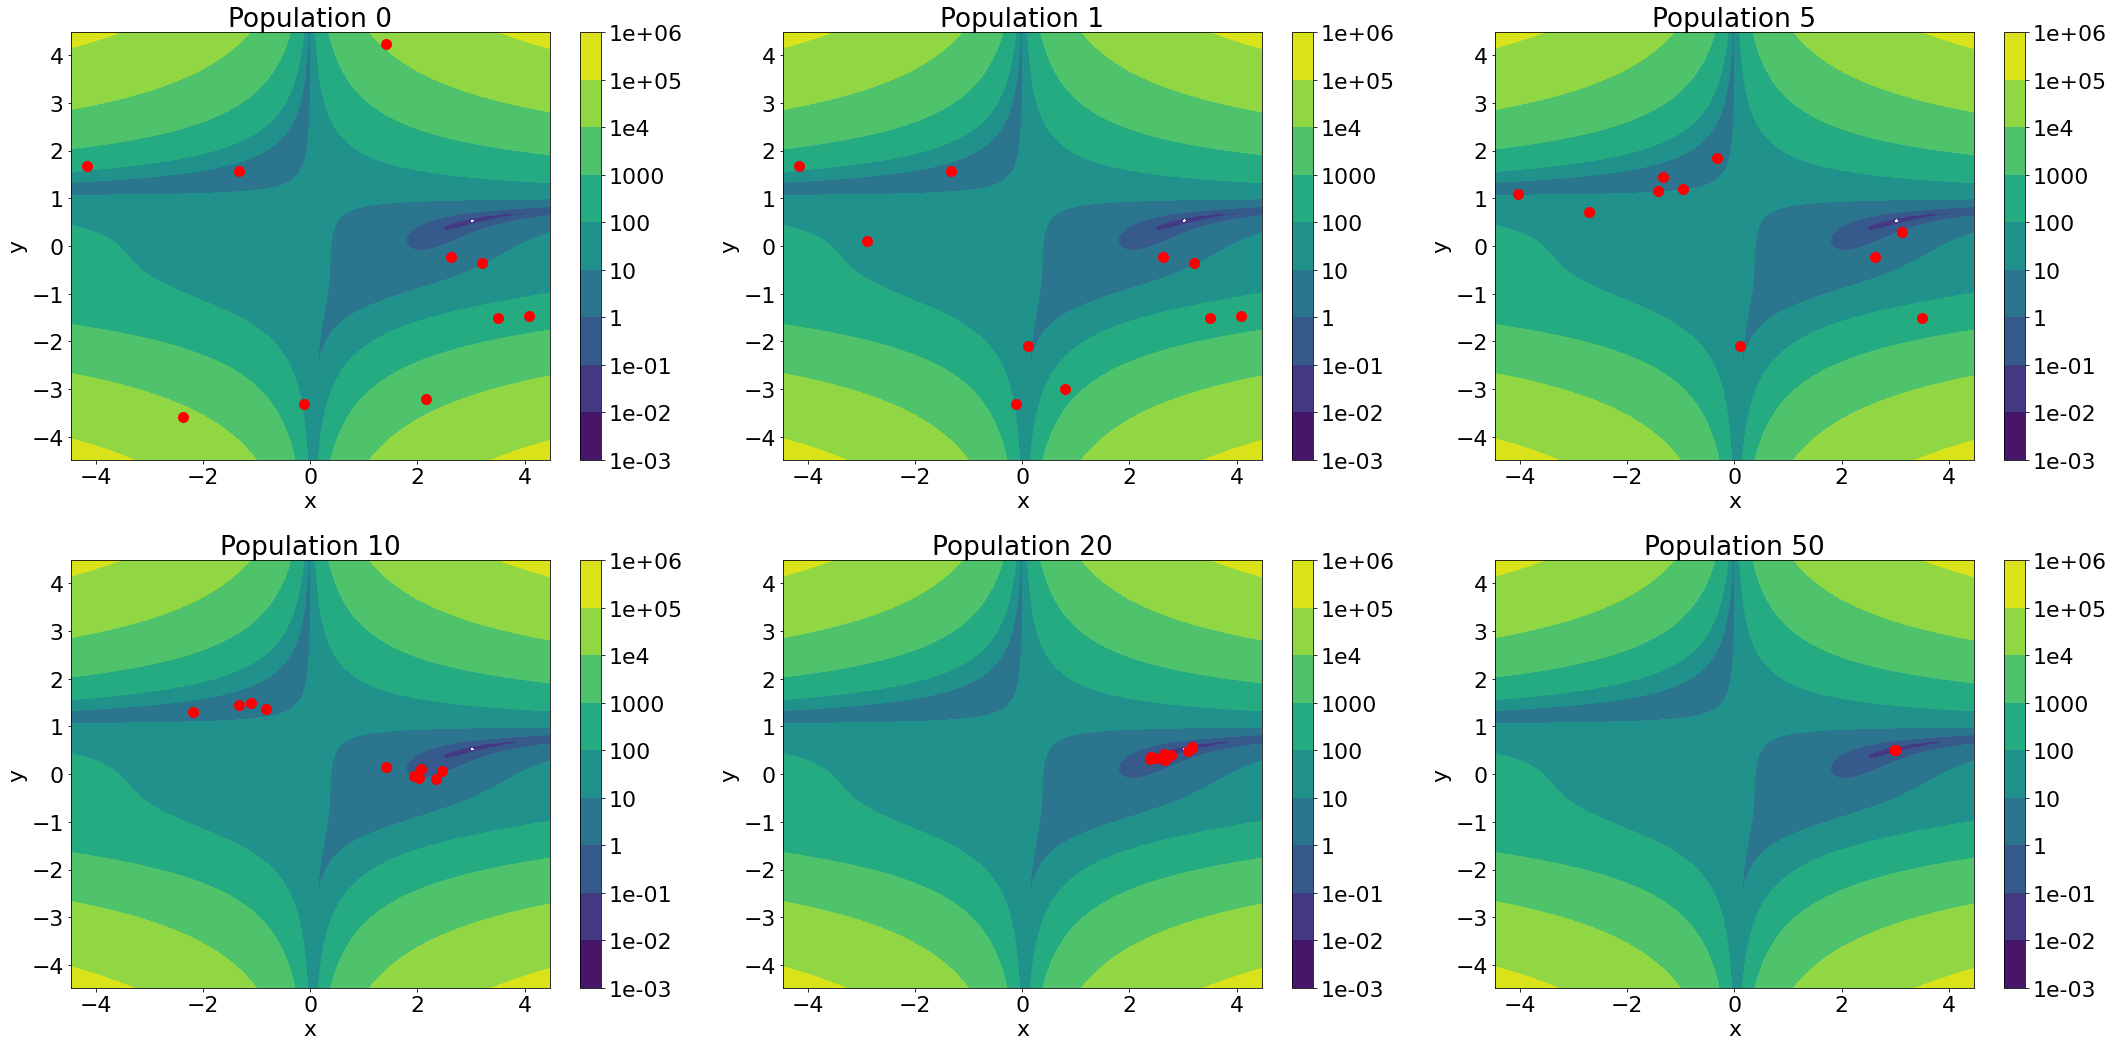

In [50]:
display_progress_2d(beale_func, optimizer.history, [-4.5, 4.5])

### Goldstein-Price Function

For optimizing the Goldstein-Price function, we used populations of size 10, set crossover probability to 0.9 and differential weight to 0.8. The error was empirically chosen to be $10^{-5}$ with at most 200 iterations to reach it. The algorithm converged to optimum in 49.4 iterations on average and average time of 34 milliseconds with precision varying from $10^{-6}$ to $10^{-8}$.

In [39]:
def goldstein_price_func(v):
    x, y = v[0], v[1]
    
    return (1 + (x + y + 1) ** 2 * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
           (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))

In [132]:
optimizer = Optimizer(population_size=10, crossover_proba=0.9, diff_weight=0.8)
print('GOLDSTEIN-PRICE FUNCTION')
print('Wikipedia: f(0, -1) = 3\n')
test_optimizer(10, optimizer, goldstein_price_func, 2, [-2, 2], max_iterations=200, eps=1e-5)

GOLDSTEIN-PRICE FUNCTION
Wikipedia: f(0, -1) = 3

Average running time: 0.03419834000087576 s
Average number of iterations: 49.4
Best optimum: [ 3.65108381e-06 -9.99989362e-01] 	 Value: 3.000000043856515
Worst optimum: [-1.19228039e-04 -9.99983412e-01] 	 Value: 3.000004127923551


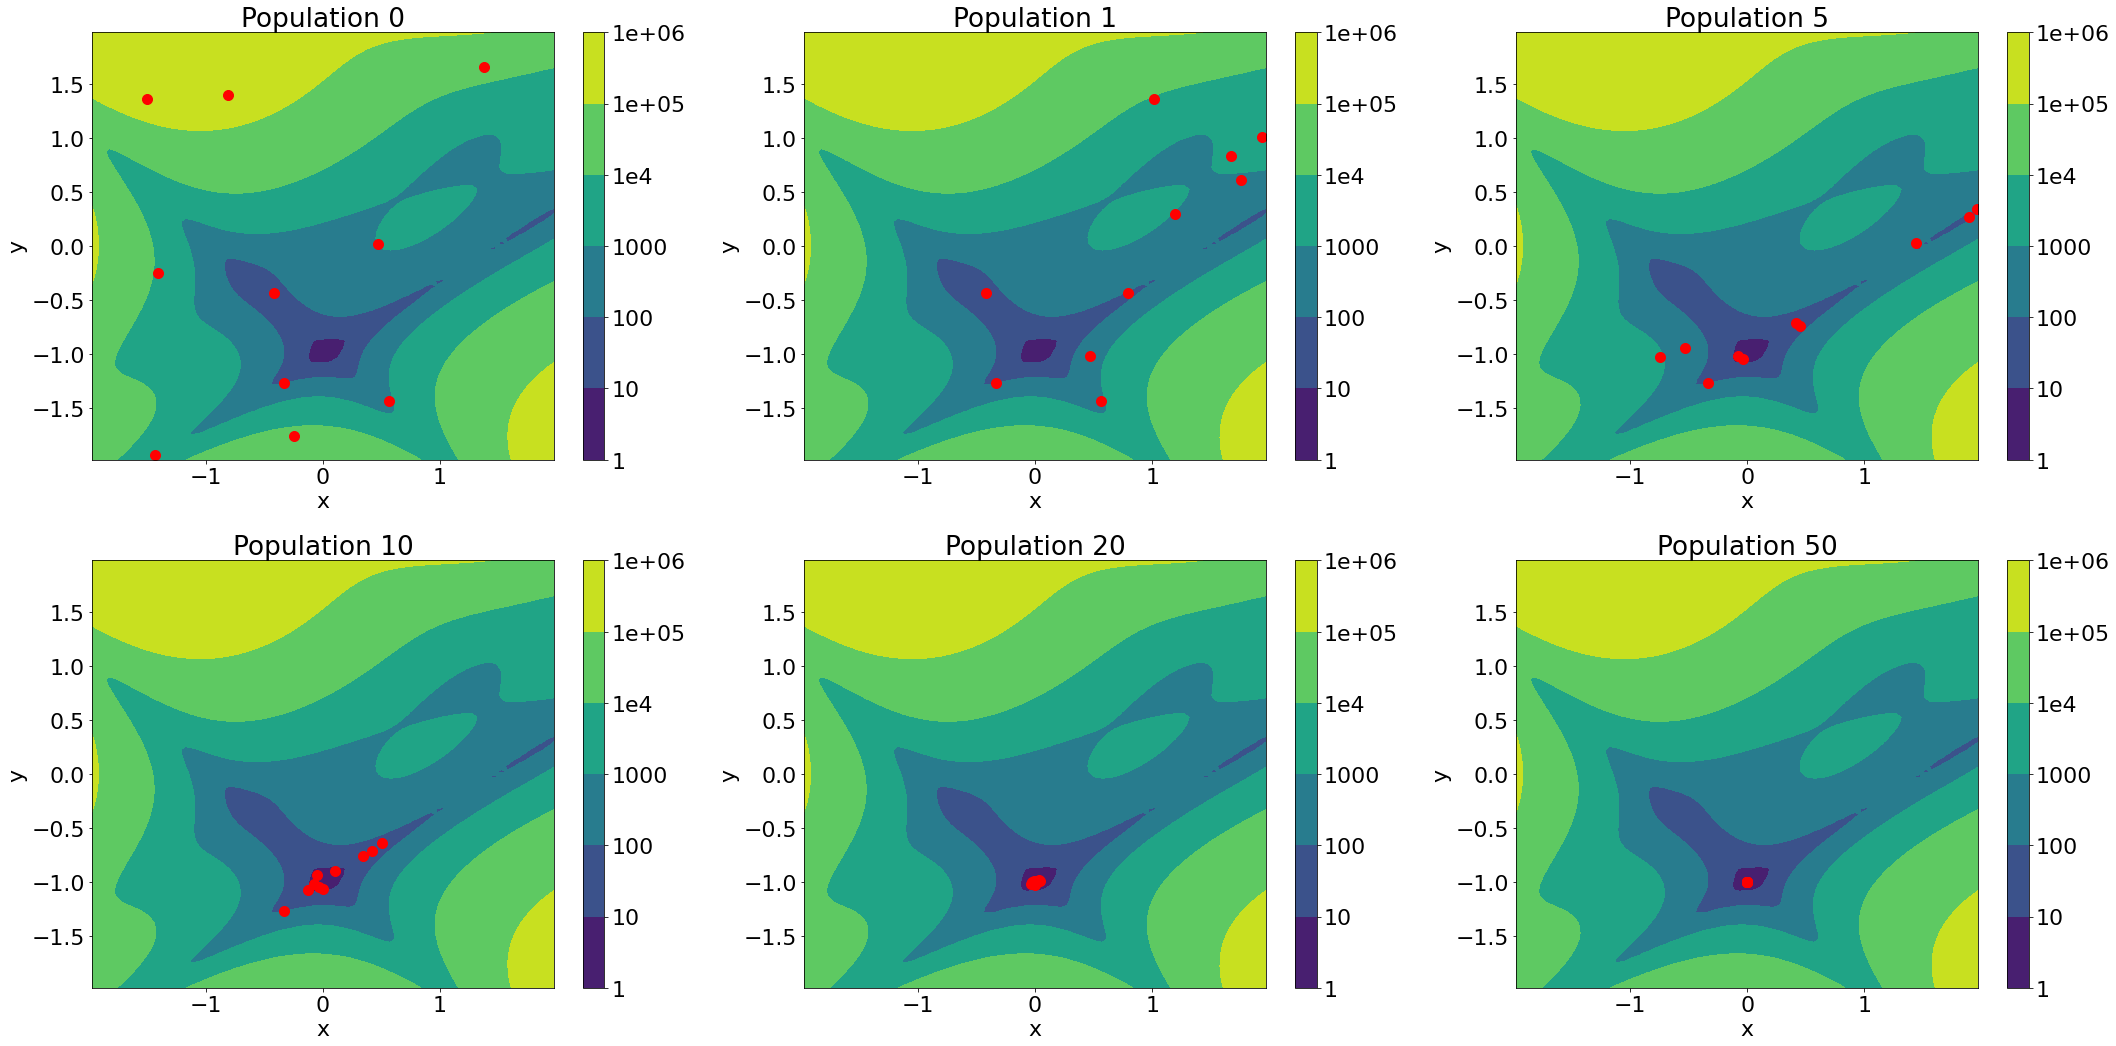

In [49]:
optimizer = Optimizer(population_size=10, crossover_proba=0.9, diff_weight=0.8)
optimizer.optimize(goldstein_price_func, 2, [-2, 2], 100)
display_progress_2d(goldstein_price_func, optimizer.history, [-2, 2])

### Three-Hump Camel Function

For optimizing the Three-Hump Camel function, we used populations of size 10, set crossover probability to 0.9 and differential weight to 0.8. The error was empirically chosen to be $10^{-5}$ with at most 200 iterations to reach it. The algorithm converged to optimum in 39.3 iterations on average and average time of 20 milliseconds with precision varying from $10^{-6}$ to $10^{-8}$.

In [45]:
def three_hump_camel_func(v):
    x, y = v[0], v[1]
    
    return 2 * x ** 2 - 1.05 * x ** 4 + x ** 6 / 6 + x * y + y ** 2

In [133]:
optimizer = Optimizer(population_size=10, crossover_proba=0.9, diff_weight=0.8)
print('THREE-HUMP CAMEL FUNCTION')
print('Wikipedia: f(0, 0) = 0\n')
test_optimizer(10, optimizer, three_hump_camel_func, 2, [-5, 5], max_iterations=200, eps=1e-5)

THREE-HUMP CAMEL FUNCTION
Wikipedia: f(0, 0) = 0

Average running time: 0.020553809998818905 s
Average number of iterations: 39.3
Best optimum: [-9.43221276e-05 -1.79678510e-04] 	 Value: 6.702535354641524e-08
Worst optimum: [ 0.001004   -0.00028651] 	 Value: 1.8104569486762353e-06


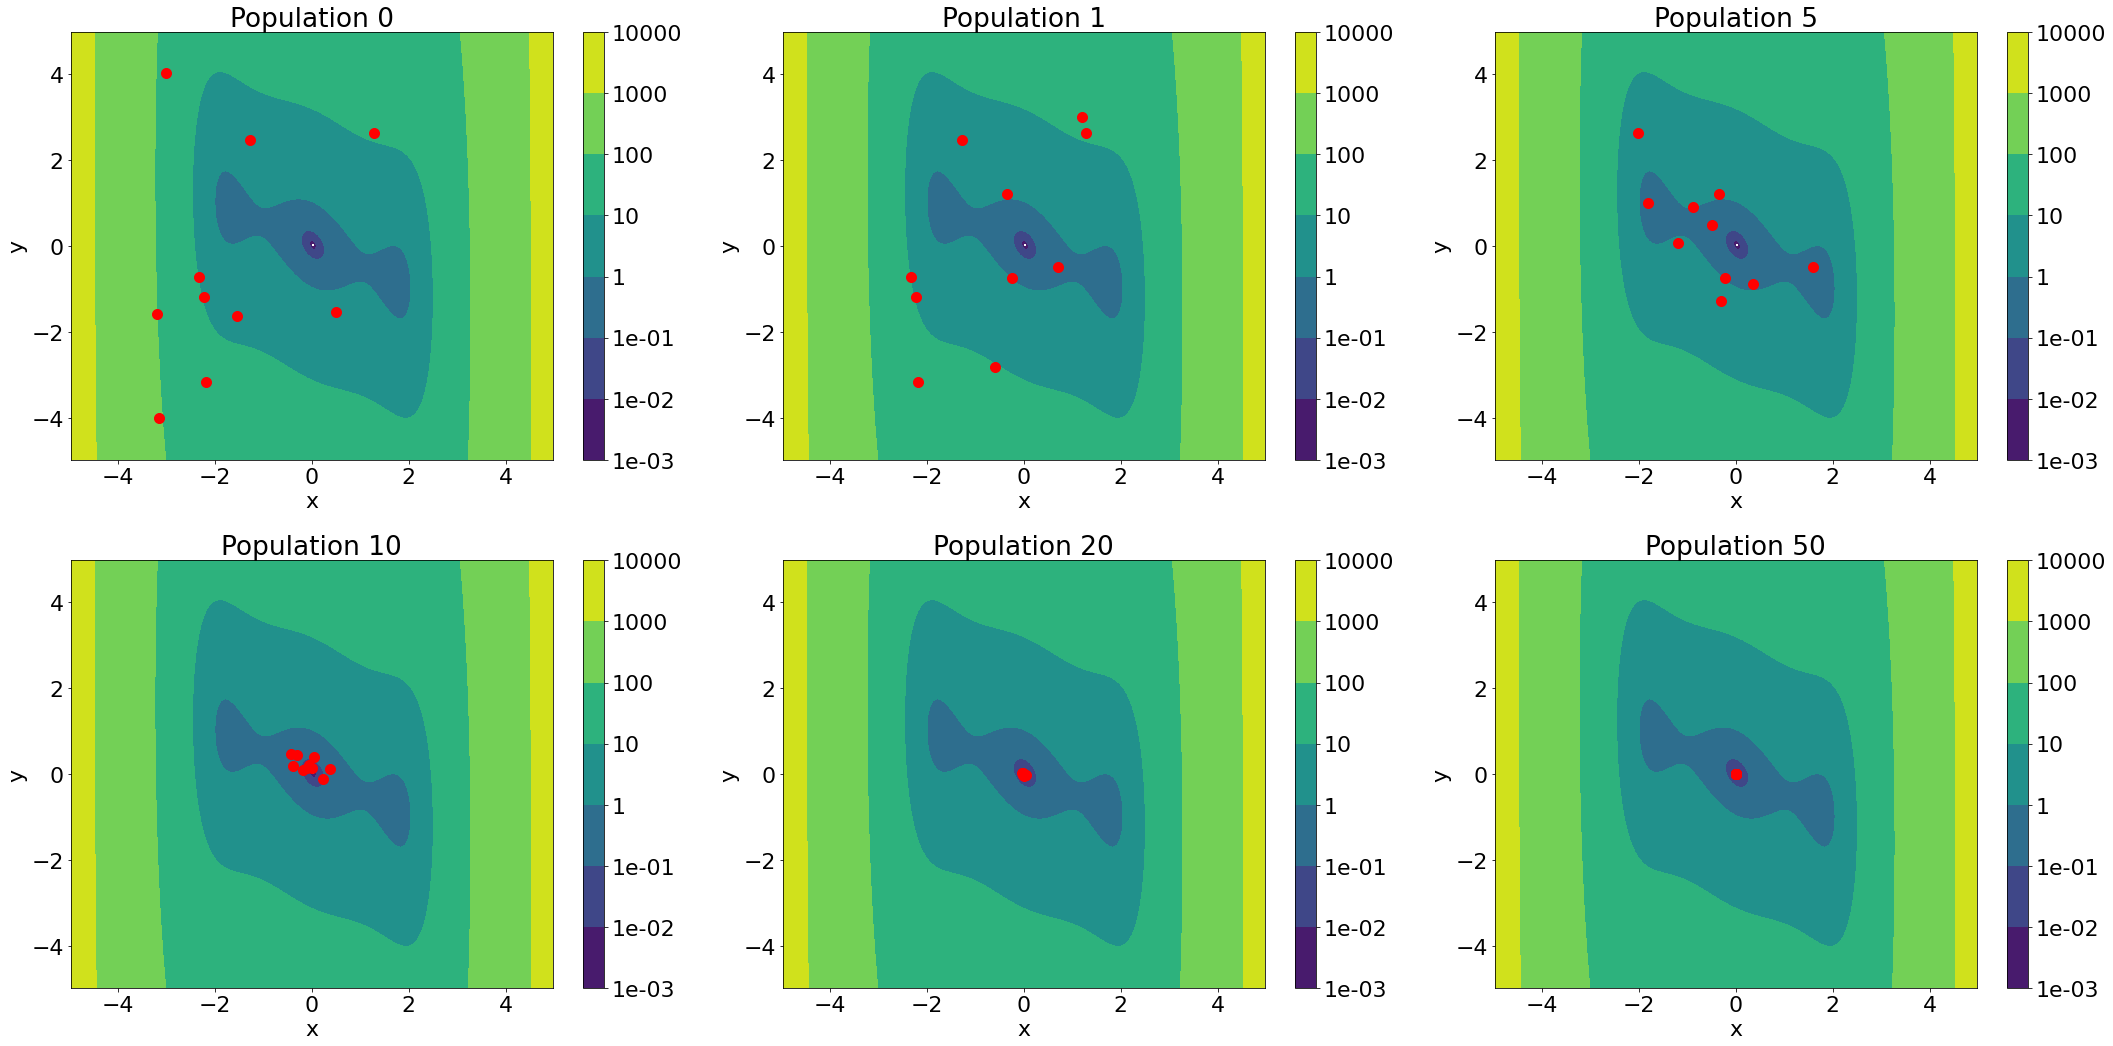

In [48]:
optimizer = Optimizer(population_size=10, crossover_proba=0.9, diff_weight=0.8)
optimizer.optimize(three_hump_camel_func, 2, [-5, 5], 100)
display_progress_2d(three_hump_camel_func, optimizer.history, [-5, 5])

### Eggholder Function

For optimizing the Eggholder Function function, we had to increase the population size to 50 and reduce the error to $10^{-10}$ for good precision. The reason for increasing the population is the nature of the function itself, it has numerous local minimums. With less points spread, the optimizer was guaranteed to find the optimum in 10 attempts, but for some tests it converged to a suboptimal value. Maximum number of iterations was set to 500. Crossover probability was set to 0.9 and differential weight was set to 0.8. The algorithm converged to optimum in 93.8 iterations on average and average time of 346 milliseconds with precision around $10^{-10}$.

In [5]:
def eggholder_func(v):
    x, y = v[0], v[1]
    
    return -(y + 47) * np.sin(np.sqrt(np.abs(x / 2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))

In [38]:
optimizer = Optimizer(population_size=50, crossover_proba=0.9, diff_weight=0.8)
print('EGGHOLDER FUNCTION')
print('Wikipedia: f(512, 404.2319) = -959.6407\n')
test_optimizer(10, optimizer, eggholder_func, 2, [-512, 512], max_iterations=500, eps=1e-10)

EGGHOLDER FUNCTION
Wikipedia: f(512, 404.2319) = -959.6407

Average running time: 0.3462186899999324 s
Average number of iterations: 93.8
Best optimum: [512.         404.23180504] 	 Value: -959.640662720851
Worst optimum: [512.         404.23180406] 	 Value: -959.6406627208496


### Schaffner Function N.4

In case of Schaffner Function N.4, we again had to increase the population size to 50, since this function has many local minimums as well (so it is important to not get stuck in them). For good precision, the error of $10^{-5}$ was enough. Maximum number of iterations was set to 500. Crossover probability was set to 0.9 and differential weight was set to 0.8. The algorithm converged to optimum in 279.4 iterations on average and average time of 904 milliseconds with precision about $10^{-6}$.

In [22]:
def schaffner_4_func(v):
    x, y = v[0], v[1]
    
    return 0.5 + (np.cos(np.sin(np.abs(x ** 2 - y ** 2))) ** 2 - 0.5) / (1 + 0.001 * (x ** 2 + y ** 2)) ** 2

In [32]:
optimizer = Optimizer(population_size=50, crossover_proba=0.9, diff_weight=0.8)
print('SCHAFFNER FUNCTION N.4')
print('Wikipedia: f(0, 0.125313) = 0.292579\n'
     '           f(0, -0.125313) = 0.292579\n'
     '           f(0.125313, 0) = 0.292579\n'
     '           f(-0.125313, 0) = 0.292579\n')
test_optimizer(10, optimizer, schaffner_4_func, 2, [-100, 100], max_iterations=500, eps=1e-5)

SCHAFFNER FUNCTION N.4
Wikipedia: f(0, 0.125313) = 0.292579
           f(0, -0.125313) = 0.292579
           f(0.125313, 0) = 0.292579
           f(-0.125313, 0) = 0.292579

Average running time: 0.9040226799998891 s
Average number of iterations: 279.4
Best optimum: [-0.00141582 -1.25313934] 	 Value: 0.2925786338246038
Worst optimum: [1.25297242 0.00444084] 	 Value: 0.29257872802764284


# Task 3

Let us analyze how many configurations there is in total for 2x2 Rubik's cube. There are $8!$ permutations of 8 cubies, each cubie can take three states (a cubie can be rotated with a series of moves, so that it takes the same place but the colors are in different order; basically, the sides get "rotated" and there are only 3 such rotations). All the cubies are different. Thus, there are $8! \cdot 3^8 = 264 539 520$ possible configurations. Excluding symmetries (the cube can be rotated but the configuration stays the same; there are 24 such rotations), we reduce the number of configurations by $24$. Therefore, the total number of configurations is $11022480$ (about 1 million).  
  
Now, let us count the number of states that can be reached in exactly $k$ steps. There are only face rotations for 2x2 cube, each one comes in 2 types: clockwise or counterclockwise. There are 6 faces, so in total there are $6 \cdot 2 = 12$ possible moves at each step. Thus, the number of states that can be reached in $k$ steps is bounded from above by $12^k$. Some states will repeat.  
  
God's number of a 2x2 cube can be found via building the states tree. Reached states should be identified, coded and cached, so that the tree won't have the repeated branches.  